# Articles Recommender Engine for IBM Watson Studio Platform
 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

In [1]:
!pip install progressbar2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.model_selection import train_test_split
from collections import defaultdict
from IPython.display import HTML
import progressbar
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
df_content['article_id'] = df_content['article_id'].astype(str)
type(df_content['article_id'][0])
df['article_id'] = df['article_id'].astype(str)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:

#df.email.value_counts()
df[['title', 'email']].describe()


,title,email
count,45993,45976
unique,714,5148
top,use deep learning for image classification,2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq,937,364


In [5]:
df.shape

(45993, 3)

In [6]:
# Number of unique titles or articles
df['title'].value_counts().count()

714

In [7]:
#user_article = 
df[['article_id', 'email']].count()#.median()

article_id    45993
email         45976
dtype: int64

In [8]:
df['email'].isnull().sum()

17

In [9]:
median_user_article_interactions = df['email'].value_counts().median()
average_user_article_interactions = round(df['email'].value_counts().mean(), 1)
max_num_of_user_article_interactions = df['email'].value_counts().max()
df['email'].value_counts().max()


364

In [10]:
# Fill in the median and maximum number of user_article interactios below

median_val = median_user_article_interactions  
max_views_by_user = max_num_of_user_article_interactions 

In [11]:
print("50% of individuals interact with {} number of articles or fewer".format(median_val))
print("The maximum number of user-article interactions by any 1 user is {}.".format(max_views_by_user))
print("The average number of user-article interactions  is {}.".format(average_user_article_interactions))

50% of individuals interact with 3.0 number of articles or fewer
The maximum number of user-article interactions by any 1 user is 364.
The average number of user-article interactions  is 8.9.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [12]:
# Find and explore duplicate articles
num_of_duplicated_articles= df_content.duplicated().sum()
print("The content dataframe contains {} duplicates".format(num_of_duplicated_articles))


The content dataframe contains 0 duplicates


In [13]:
# Remove any rows that have the same article_id - only keep the first
df1 = df.drop_duplicates(subset=['article_id'], keep = 'first')
print(f"The number of unique articles that have an interaction with a user is {df1.shape[0]}")

The number of unique articles that have an interaction with a user is 714


In [14]:
df_content1 = df_content.drop_duplicates(subset=['article_id'])

In [15]:
df_content['article_id'].nunique()

1051

`3.` Finding answers to the following questions:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [16]:
unique_articles_with_interactions = df['article_id'].nunique()
unique_articles_in_IBM_platform = df_content['article_id'].nunique()
unique_users = df['email'].nunique()
user_article_interactions = df.shape[0]
print("There are {} unique users in IBM platform.".format(unique_users))
print("There are {} unique articles that have at least one interaction."\
      .format(unique_articles_with_interactions))
print("The number of unique articles on the IBM platform is {}."\
      .format(unique_articles_in_IBM_platform))
print("The number of user-article interactions in the IBM platform is {}"\
      .format(user_article_interactions))

There are 5148 unique users in IBM platform.
There are 714 unique articles that have at least one interaction.
The number of unique articles on the IBM platform is 1051.
The number of user-article interactions in the IBM platform is 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [17]:
most_viewed_article_id = df.article_id.value_counts().index[0]
number_of_times_most_viewed_articles_was_viewed = df.article_id.value_counts().max()

In [18]:
print("The most viewed article in the dataset has id {} .".format(most_viewed_article_id))
print("The most viewed article in the dataset was viewed {} times."\
      .format(number_of_times_most_viewed_articles_was_viewed ))

The most viewed article in the dataset has id 1429.0 .
The most viewed article in the dataset was viewed 937 times.


In [19]:
most_viewed_article_id = df.article_id.value_counts().index[0]
max_views =  df.article_id.value_counts().max()   # The most viewed article in the dataset was viewed how many times?

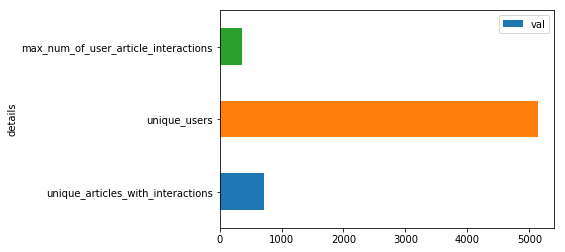

In [20]:
info = {'details': ['unique_articles_with_interactions', 'unique_users', 'max_num_of_user_article_interactions'], \
        'val':[unique_articles_with_interactions, unique_users,max_num_of_user_article_interactions ]}
dfp = pd.DataFrame(info)
dfp.plot.barh(x = 'details', y = 'val', rot=0)


In [21]:

def email_mapper():
    """
    A function that maps the users emails to generate user ids:
    """
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded




email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [22]:
df.user_id.nunique()

5149

In [23]:
#email_encoded 
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [24]:
user_article_interactions = df.shape[0]
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles_with_interactions,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': unique_articles_in_IBM_platform 
}

# Testing the dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [25]:
df.title.value_counts()[:6]

use deep learning for image classification                      937
insights from new york car accident reports                     927
visualize car data with brunel                                  671
use xgboost, scikit-learn & ibm watson machine learning apis    643
predicting churn with the spss random tree algorithm            627
healthcare python streaming application demo                    614
Name: title, dtype: int64

In [26]:
df.article_id.value_counts().index #[:5]

Index(['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0',
       '1170.0', '1162.0', '1304.0',
       ...
       '1072.0', '1092.0', '1233.0', '974.0', '1113.0', '1119.0', '653.0',
       '1202.0', '675.0', '1266.0'],
      dtype='object', length=714)

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [27]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # series of top n articles with titles as the index and frequency as values
    top_articles = df.title.value_counts()[:n]
    #convert the index to numpy array
    top_articles = np.array(top_articles.index)
    # Return the top article titles from df (not df_content)
    return top_articles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Get a Series object with article ids as index and frequency as values
    top_articles = df.article_id.value_counts()
    # Convert the index to array and return first n values
    
    top_articles = np.array(top_articles.index)[:n]
    
    return top_articles # Return the top article ids

In [28]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification'
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'predicting churn with the spss random tree algorithm'
 'healthcare python streaming application demo'
 'finding optimal locations of new store using decision optimization'
 'apache spark lab, part 1: basic concepts'
 'analyze energy consumption in buildings'
 'gosales transactions for logistic regression model']
['1429.0' '1330.0' '1431.0' '1427.0' '1364.0' '1314.0' '1293.0' '1170.0'
 '1162.0' '1304.0']


In [29]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [30]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # The dimension of the matrix = n_users x n_articles
        
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack().notnull().astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [31]:
user_item.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df_content.head(1)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0


In [33]:
df_content.shape
#df.shape

(1056, 5)

In [34]:
# Define a list and a dictionary to map the doc_description to numerical values
desc_mapper = []
doc_dic = dict()
iters = 1
for val in df_content['doc_description']:
    if val not in doc_dic:
        doc_dic[val] = iters
        iters+=1
    desc_mapper.append(doc_dic[val])
len(desc_mapper)

1056

In [35]:
# Define a list and a dictionary to map the doc_full_name to numerical values
name_mapper = []
doc_dic = dict()
iters = 1
for val in df_content['doc_full_name']:
    if val not in doc_dic:
        doc_dic[val] = iters
        iters+=1
    name_mapper.append(doc_dic[val])
len(name_mapper)

1056

In [36]:
df_content['name'] = name_mapper
df_content['description'] = desc_mapper

In [37]:
df.groupby(['user_id', 'article_id'])['title'].count().unstack().notnull().astype(int).head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
user_item.sum(axis=1)[4] 
df.article_id = df.article_id.astype(str)

In [39]:
## Tests:Checking the correctness of the codes
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [40]:
#user_item.dot(np.transpose(user_item))
user_item.sum(axis=1).max() 

135

In [41]:
user_item_df = pd.DataFrame(user_item)
idx1 = 12
#user_item_df[user_item_df['user_id'] == idx1]
user_item_df.head(2)

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
num = 0
for x in user_item_df.iloc[2, :]:
    if x ==1:
       num+=1
num1 = []
y = user_item_df.iloc[2, :]
for i in y.index:
    if y[i] == 1:
        num1.append(i)
num
#y

40

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [43]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # convert the user_item matrix  to dataframe
    user_item_df = pd.DataFrame(user_item)
    # perform dot product between user_item_df and itself at the user_id
    similar_users = user_item_df.dot(user_item_df.iloc[user_id])
    
    
    # sort similar_users 
    similar_users  = similar_users.sort_values(ascending = False)

    
    # remove the user's own  id
    similar_users = similar_users.drop(user_id)
    # create list of just the user ids using the Series index
    most_similar_users = list(similar_users.index)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [44]:
user_id = 1
a = user_item.dot(user_item.iloc[user_id]).sort_values(ascending=False)
b = find_similar_users(1)
a = a.drop(user_id)
a = list(a.index)
a == b

True

In [45]:
# Spot check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [2, 3764, 49, 98, 3697, 10, 2982, 21, 3782, 290]
The 5 most similar users to user 3933 are: [3934, 49, 126, 2742, 1062]
The 3 most similar users to user 46 are: [4527, 120, 3419]


`3.` Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles to recommend.  The functions below would return the articles we would recommend to each user. 

In [46]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # initialize an empty list
    article_names = [df[df['article_id'] == idx]['title'].values[0] for idx in article_ids]
        
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    #Get the article ids at the user_id and transpose the result
    #article_ids = user_item[user_item.index==user_id].isin([1]).astype(int).T
    
    # Get the article ids of the articles the user actually interacted with as a list
    #article_ids = article_ids[article_ids[user_id] == 1].index.tolist()
    article_ids = user_item.loc[user_id, :][user_item.loc[user_id, :].values == 1].index.astype('str')
    article_ids = list(article_ids)
    # Use the get_article_names function to get the article names
    article_names = get_article_names(article_ids)
    # return the ids and names
    return article_ids, article_names 


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    most_similar_user_ids = find_similar_users(user_id)
    recs = np.array([])
    ids_articles_seen_by_user, _ = get_user_articles(user_id)
    for idx in most_similar_user_ids:
        # article ids interacted with by each similar user
        similar_user_articles = get_user_articles(idx)[0]
        # Get articles to recommend
        rec_new = np.setdiff1d(similar_user_articles, ids_articles_seen_by_user, assume_unique=True)
        recs=  np.unique(np.concatenate([rec_new, recs], axis=0))
        if len(recs) > m-1:
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [47]:
# Check Results . Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10)) 

['how to choose a project to practice data science',
 '7 types of job profiles that makes you a data scientist',
 'using deep learning to reconstruct high-resolution audio',
 'data tidying in data science experience',
 'a comparison of logistic regression and naive bayes ',
 'access mysql with r',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'pixiedust: magic for your python notebook',
 'airbnb data for analytics: new york city reviews',
 'practical tutorial on random forest and parameter tuning in r']

In [48]:
# Testing the functions here 
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function we  wrote earlier.

In [49]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Drop the user user_id row from ther user_item matrix
    #user_item1 = user_item.copy().drop(user_id)
    # Get the user_ids as matrix and assign it to the neighbors ids
    users_list = user_item.index.tolist()
    neighbors_user_id = [user for user in users_list if user!=user_id]
    
    
    neighbors_df = pd.DataFrame(columns = ['neighbor_id', 'similarity', 'num_interactions'])
    #iterate through list to calculate dot product and append to similarity dataframe
    for k in neighbors_user_id:
        similarity = np.dot(user_item.loc[k,:],user_item.loc[user_id,:])
        num_interactions = user_item.loc[k,:].sum()
        s = pd.DataFrame([[k, similarity, num_interactions]], columns = ["neighbor_id", "similarity", "num_interactions"])
        neighbors_df = neighbors_df.append(s, ignore_index = True) 
    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'num_interactions'], ascending=False)
    # Return the dataframe 
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Get the neighbors sorted by number of interactions with article
    neighbors_ids = list(get_top_sorted_users(user_id).neighbor_id)
    recs = []
    
    ids_articles_seen_by_user, article_names = get_user_articles(user_id)
    for idx in neighbors_ids:
        # article ids interacted with by each similar user
        similar_user_articles_id, similar_user_articles_names= get_user_articles(idx)
        # Get articles to recommend
        rec_new = np.setdiff1d(np.array(similar_user_articles_id), np.array(ids_articles_seen_by_user))
        recs1=  np.setdiff1d(rec_new, np.array(recs))
        recs1 = list(recs1)
        recs.extend(recs1)
        if len(recs) > m-1:
            break 
    recs = recs[:m]       
    rec_names = get_article_names(recs)
    
    
    return recs, rec_names

In [50]:

%time get_top_sorted_users(1).head()

CPU times: user 11.2 s, sys: 64.1 ms, total: 11.2 s
Wall time: 22.4 s


,neighbor_id,similarity,num_interactions
3931,3933,35,35
21,23,17,135
3780,3782,17,135
201,203,15,96
4457,4459,15,96


In [51]:
%%time
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1014.0', '1059.0', '109.0', '111.0', '1157.0', '1162.0', '1164.0', '1172.0', '1186.0', '12.0']

The top 10 recommendations for user 20 are the following article names:
['1448    i ranked every intro to data science course on...\nName: title, dtype: object', 'airbnb data for analytics: amsterdam calendar', 'tensorflow quick tips', 'tidy up your jupyter notebooks with scripts', 'airbnb data for analytics: washington d.c. listings', 'analyze energy consumption in buildings', 'analyze open data sets with pandas dataframes', 'apache spark lab, part 3: machine learning', 'connect to db2 warehouse on cloud and db2 using scala', 'timeseries data analysis of iot events by using jupyter notebook']
CPU times: user 11.7 s, sys: 83.8 ms, total: 11.8 s
Wall time: 23.7 s


In [52]:
%%time
print(get_top_sorted_users(1)['neighbor_id'].iloc[0])
print(get_top_sorted_users(131)['neighbor_id'].iloc[9])

3933
3910
CPU times: user 22.6 s, sys: 234 ms, total: 22.8 s
Wall time: 45.4 s


In [53]:
get_top_sorted_users(131).iloc[0:18] #['neighbor_id'].

,neighbor_id,similarity,num_interactions
3868,3870,74,75
3780,3782,39,135
22,23,38,135
201,203,33,96
4457,4459,33,96
48,49,29,101
3695,3697,29,100
97,98,29,97
3762,3764,29,97
3908,3910,25,60


`5.` Using the functions from above to correctly fill in the solutions to the dictionary below.  Then test the dictionary against the solution.  

In [54]:
# Tests with a dictionary of results
# The code to answer each question below.
user1_most_sim =  get_top_sorted_users(1)['neighbor_id'].values[0]   # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].values[10]     # Find the 10th most similar user to user 131

In [55]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?    Can we think of a better way we might make recommendations? Some explanation.

When presented with a new user not among the existing users, recommending the most popular articles using both the **get_top_articles(n, df=df)** and the **get_top_article_ids(n, df=df)** functions based on the number of number of times  users and articles' interacted would be ideal. However, this approach is not optimal because not all users are interested in the most popular articles. 
A better approach would be to make recommendations based on the type of articles they might be interested in via content based recommendations.

`7.` Using the existing functions, provide the top 10 recommended articles we would provide for a new user below.  We can test your function against existing solution to make sure we are correct with how we might make a recommendation.

In [56]:
new_user_recs = get_top_article_ids(10, df=df)
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


In [57]:
new_user = '0.0'

# What would be the recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# A list of the top 10 articles to be recommended to the new user are
new_user_recs = get_top_articles(10) 

new_user_recs

array(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'], dtype=object)

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations </a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  We will consider content to be the  **doc_description**.  There isn't one way to create a content based recommendation, especially considering that each of **doc_full_name, doc_body and doc_description** columns hold content related information.  

`1.` The functions below are used to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  The input values are currently set with one idea in mind that we may use to make content based recommendations. There is a lot of flexibility in how one might make these recommendations. One additional idea is that we might want to choose the most popular recommendations that meet the desired 'content criteria', but we will go ahead with content based on the **doc_description**


In [58]:
# Change the datatype of article_id
df.article_id = df['article_id'].astype('float')
df.article_id = df['article_id'].astype('int')
df_content.article_id = df_content['article_id'].astype('float')
df_content.article_id = df_content['article_id'].astype('int')

In [59]:
# Merge the df and df_content dataframes
big_df = df.merge(df_content, how='left', on='article_id')

# Percentage of null values
big_df.isnull().sum().sum()/np.product(big_df.shape)
articles_not_in_content_df = big_df[big_df.doc_body.isnull() == True]['article_id']#.unique()
articles_not_in_content_df.shape
# Drop null values
df_new1 = big_df.dropna()
df_new1['user_id'].nunique()

4258

In [60]:
df_new1.head(1)

,article_id,title,user_id,doc_body,doc_description,doc_full_name,doc_status,name,description
7,593,upload files to ibm data science experience us...,8,Homepage Follow Sign in / Sign up Homepage * H...,Data Science Experience (DSX) is a unified ana...,Upload Files to IBM Data Science Experience Us...,Live,594.0,577.0


In [61]:
# Create Dummy values for the description column and concatenate with the df_new1
df2=  pd.concat([df_new1, pd.get_dummies(df_new1['description'], prefix_sep='_', drop_first=True)], axis=1)
df2.head()

,article_id,title,user_id,doc_body,doc_description,doc_full_name,doc_status,name,description,3.0,...,999.0,1002.0,1004.0,1011.0,1015.0,1016.0,1017.0,1020.0,1021.0,1023.0
7,593,upload files to ibm data science experience us...,8,Homepage Follow Sign in / Sign up Homepage * H...,Data Science Experience (DSX) is a unified ana...,Upload Files to IBM Data Science Experience Us...,Live,594.0,577.0,0,...,0,0,0,0,0,0,0,0,0,0
10,993,configuring the apache spark sql context,11,* Home\r\n * Community\r\n * Projects\r\n * Bl...,The Apache Spark website documents the propert...,Configuring the Apache Spark SQL Context,Live,994.0,967.0,0,...,0,0,0,0,0,0,0,0,0,0
11,14,got zip code data? prep it for analytics. – ib...,12,Raj Singh Blocked Unblock Follow Following Dev...,Who are those people lurking behind the statis...,Got zip code data? Prep it for analytics. – IB...,Live,15.0,15.0,0,...,0,0,0,0,0,0,0,0,0,0
15,542,getting started with python,14,Getting started with python. This book is inte...,This book is intended for anyone who works wit...,Getting started with Python,Live,543.0,527.0,0,...,0,0,0,0,0,0,0,0,0,0
16,12,timeseries data analysis of iot events by usin...,11,Skip to main content IBM developerWorks / Deve...,This recipe showcases how one can analyze the ...,Timeseries Data Analysis of IoT events by usin...,Live,13.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Get the content from the description dummy variables
article_content = np.array(df2.iloc[:, 9:])
article_content_T = np.transpose(article_content)
article_product = article_content.dot(article_content_T)

In [74]:
# save the article_product as a pickle file
pickle.dump(article_product, open("article_content_product.pkl", 'wb'))

In [62]:
# Load the article product file
article_product = pd.read_pickle("article_content_product.pkl")

In [63]:
# Get the unique users 
users = np.unique(df2['user_id'])

In [64]:
def find_similar_articles(article_id):
    '''
    INPUT
    article_id - an article_id 
    OUTPUT
    similar_articles - an array of the most similar articles by description or top popular articles
    '''
    # find the row of each article_id
    # Check if the article id exists.  if not return popular articles
    if(len(np.where(df2['article_id'] == article_id)[0])==0):
        print("The article id {} is not found.\nRecommendations of top 10 popular articles.".format(article_id))
        print('='*90)
        similar_articles = get_top_articles(10, df=df)
    else:
        article_idx = np.where(df2['article_id'] == article_id)[0][0]
    
        # find the most similar article_id indices - they need to be the same for all content
        similar_idxs = np.where(article_product[article_idx] == np.max(article_product[article_idx]))[0]
    
        # pull the article titles based on the indices
        similar_articles = np.array(df.iloc[similar_idxs, ]['title'])
        
    return similar_articles


# Defined earlier
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # initialize an empty list
    article_names = [df[df['article_id'] == idx]['title'].values[0] for idx in article_ids]
        
    
    return article_names # Return the article names associated with list of article ids


In [65]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''
    # Create dictionary to return with users and ratings
    recs = defaultdict(set)
    
    # How many users for progress bar
    n_users = len(users)

    
    # Create the progressbar

    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    # For each user
    for user in users:
        
        # Update the progress bar
        cnter+=1 
        bar.update(cnter)

        # Pull only the articles the user has seen
        content_temp = df2[df2['user_id'] == user]
        article_temp = np.array(content_temp['article_id'])
        article_names = np.array(get_article_names(article_temp))

        # Look at each of the articles (highest ranked first), 
        # pull the movies the user hasn't seen that are most similar
        # These will be the recommendations - continue until 10 recs 
        # or you have depleted the movie list for the user
        for article in article_temp:
            rec_article = find_similar_articles(article)
            temp_recs = np.setdiff1d(rec_article, article_names)
            recs[user].update(temp_recs)

            # If there are more than 
            if len(recs[user]) > 9:
                break

    bar.finish()
    
    return recs

In [66]:
recs = make_content_recs()

[========================================================================] 100%


In [67]:

users_without_all_recs = []
users_with_all_recs = []
no_recs = []
for user, article_recs in recs.items():
    if len(article_recs) < 10:
        users_without_all_recs.append(user)
    if len(article_recs) > 9:
        users_with_all_recs.append(user)
    if len(article_recs) == 0:
        no_recs.append(user)

print("There were {} users without all 10 recommendations we would have liked to have.".format(len(users_without_all_recs)))
print("There were {} users with all 10 recommendations we would like them to have.".format(len(users_with_all_recs)))
print("There were {} users with no recommendations at all!".format(len(no_recs)))

There were 35 users without all 10 recommendations we would have liked to have.
There were 4223 users with all 10 recommendations we would like them to have.
There were 0 users with no recommendations at all!


`2.` Now that we have put together our content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?



**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.



In [68]:
# Closer look at individual user characteristics
user_items = df2[['user_id', 'article_id', 'description']]
user_by_article = user_items.groupby(['user_id', 'article_id'])['description'].max().unstack()

def articles_read(user_id):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    OUTPUT:
    movies - an array of movies the user has watched
    '''
    articles = user_by_article.loc[user_id][user_by_article.loc[user_id].isnull() == False].index.values

    return articles



In [69]:
articles_read(8)
#df2.head()

array([  14,   34,  111,  132,  142,  173,  189,  202,  302,  379,  390,
        415,  427,  528,  542,  563,  583,  593,  606,  645,  692,  695,
        723,  809,  878,  898,  943,  975,  981, 1017, 1042, 1047])

In [70]:
cnter = 0
print("Some of the article lists for users without all recommendations include:")
for user_id in users_with_all_recs:
    print(user_id)
    print(get_article_names(articles_read(user_id))[0])
    cnter+=1
    if cnter > 10:
        break

Some of the article lists for users without all recommendations include:
1
deep learning with tensorflow course by big data university
2
using deep learning to reconstruct high-resolution audio
3
timeseries data analysis of iot events by using jupyter notebook
4
working interactively with rstudio and notebooks in dsx
6
how to solve 90% of nlp problems
8
got zip code data? prep it for analytics. – ibm watson data lab – medium
9
got zip code data? prep it for analytics. – ibm watson data lab – medium
10
10 must attend data science, ml and ai conferences in 2018
11
timeseries data analysis of iot events by using jupyter notebook
12
got zip code data? prep it for analytics. – ibm watson data lab – medium
13
got zip code data? prep it for analytics. – ibm watson data lab – medium


In [71]:
i = 0
for user in users_without_all_recs:
    print(f"The recommendations for the user {user} are:\n ")
    j = 1
    for x in recs[user]:
        print(x)
        j+=1
        if j>5:
            break
    print("="*89)
    
    i+=1
    if i > 10:
        break

The recommendations for the user 300 are:
 
data model with streaming analytics and python
15 page tutorial for r
ml optimization using cognitive assistant
adolescent fertility rate (births per 1,000 women ages 15-19), worldwide
use sql with data in hadoop python
The recommendations for the user 463 are:
 
insights from new york car accident reports
The recommendations for the user 571 are:
 
how to use version control (github) in rstudio within dsx?
enjoy python 3.5 in jupyter notebooks
an introduction to stock market data analysis with r (part 1)
movie recommender system with spark machine learning
The recommendations for the user 685 are:
 
machine learning and the science of choosing
the pandas data analysis library
super fast string matching in python
ml optimization using cognitive assistant
visualize car data with brunel
The recommendations for the user 754 are:
 
real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)
fortune 100 companies
working with ibm clo

In [72]:
# make recommendations for a brand new user 
#by using knowledge based recommendations using get_top_articles(n, df=df)
print(f"Recommenddatios for a brand new user by\
using knowledge based recommendations are:")
print("="*90)
print(get_top_articles(10))
print("="*90)

# make a recommendations for a user who only has interacted with article id '1427.0'

print(find_similar_articles(1427))



Recommenddatios for a brand new user byusing knowledge based recommendations are:
['use deep learning for image classification'
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'predicting churn with the spss random tree algorithm'
 'healthcare python streaming application demo'
 'finding optimal locations of new store using decision optimization'
 'apache spark lab, part 1: basic concepts'
 'analyze energy consumption in buildings'
 'gosales transactions for logistic regression model']
The article id 1427 is not found.
Recommendations of top 10 popular articles.
['use deep learning for image classification'
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'predicting churn with the spss random tree algorithm'
 'healthcare python streaming application demo'
 'finding optimal locations of new sto

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [73]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [74]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [75]:
# Performing SVD on the User-Item Matrix here  using the built in to get the three matrices

u, s, vt = np.linalg.svd(user_item_matrix) 

In [76]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**In the lesson, there are movie ratings but the IBM Watson platform has no article ratings. The ratings had different integer values (positive) making the user-item matrix to have varying values whereas the user-item matrix in of the user and articles have only ones and zeros.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

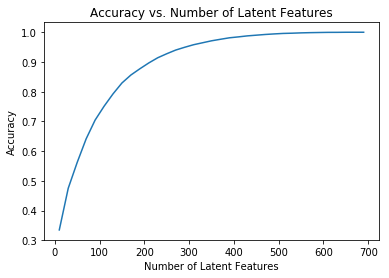

In [77]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [78]:
df.head(1)

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1


In [79]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx =  user_item_test.iloc[: , 0].index
    test_arts = user_item_test.iloc[0, :].index
    test_idx = list(test_idx)
    test_arts = list(test_arts)
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [80]:
print(len(test_idx))
#user_item_train
print(user_item_test.shape)
print(len(test_arts))
#test_arts
#test_idx['user_id'].nunique() #shape
#np.unique(test_arts)

682
(682, 574)
574


In [81]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [82]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train =  np.linalg.svd(user_item_train) 
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [83]:
# Finding the users we can make predictions for in the test set.
predictable_users = np.sort(np.array(list(set(user_item_train.index).intersection(set(user_item_test.index)))))
print(predictable_users)

[2917 3024 3093 3193 3527 3532 3684 3740 3777 3801 3968 3989 3990 3998 4002
 4204 4231 4274 4293 4487]


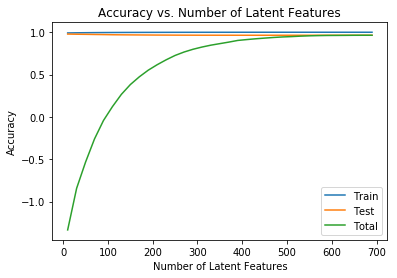

In [84]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []
sum_all_errs = []



#Decomposition for test data
row_idx = user_item_train.index.isin(test_idx)
col_idx = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idx, :]
vt_test = vt_train[:, col_idx]

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product using both train and test data
    user_item_train_preds = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_item_test_preds  = np.around(np.dot(np.dot(u_test_new, s_new), vt_test_new))    
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test.loc[predictable_users,:], user_item_test_preds)    
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
    total_error = np.add(err_train, err_test)
    sum_all_errs.append(total_error)    
    

plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train_preds.shape[0]*user_item_train_preds.shape[1]), 
         label='Train')
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/ (user_item_test_preds.shape[0]*user_item_test_preds.shape[1]),
         label='Test')
plt.plot(num_latent_feats, 1 - np.array(sum_all_errs)/ (user_item_test_preds.shape[0]*user_item_test_preds.shape[1]),label='Total')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features') 
plt.legend()
    


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Calculating some metrics such as the Root Mean Square Errors (RMSE) between the actual and predicted values could be used to measure the efficacy of the recommendations.**

In [85]:
# Calculating the RMSE for the test data
   
sse = 0
num_rated = 0
row_idx = user_item_train.index.isin(test_idx)
col_idx = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idx, :]
vt_test = vt_train[:, col_idx]

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product using both train and test data
    user_item_train_preds = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_item_test_preds  = np.around(np.dot(np.dot(u_test_new, s_new), vt_test_new))    
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test.loc[predictable_users,:], user_item_test_preds)    
    num_rated += 1
    # total errors and keep track of them
    sse+= diffs_test**2
rmse = rmse = np.sqrt(sse/num_rated)
print(rmse)
rmse2 = np.sum(np.sum(rmse))/np.product(rmse.shape) 
print(rmse2)

article_id  0     2         4        8     9         12    14        15    \
user_id                                                                     
2917         0.0   0.0  0.000000  0.00000   0.0  0.000000   0.0  0.000000   
3024         0.0   0.0  0.000000  0.00000   0.0  1.000000   0.0  0.000000   
3093         0.0   0.0  0.000000  0.00000   0.0  0.000000   0.0  0.000000   
3193         0.0   0.0  0.000000  0.00000   0.0  0.000000   0.0  0.000000   
3527         0.0   0.0  0.000000  0.00000   0.0  0.000000   0.0  0.000000   
3532         0.0   0.0  0.000000  0.92582   0.0  1.000000   0.0  0.000000   
3684         0.0   0.0  0.000000  0.00000   0.0  0.000000   0.0  0.000000   
3740         0.0   0.0  0.000000  0.00000   0.0  1.000000   0.0  0.000000   
3777         0.0   0.0  0.000000  0.00000   0.0  0.000000   0.0  0.000000   
3801         0.0   0.0  0.000000  0.00000   0.0  0.447214   0.0  0.000000   
3968         0.0   0.0  0.000000  0.00000   0.0  0.000000   0.0  0.792825   

#### The result above shows that the single value decomposition approach is very efficient.

<a id='conclusions'></a>
### Extras/ Conclusion
Using the workbook, we could now save the recommendations for each user, develop a class to make new predictions and update your results, and make a flask/dash/streamlit app to deploy the results.  

####  Discussion about the results, as well as a method by which to test how well the recommendation engine is working in practice.

In this project, four different ways of making recommendations were explored, namely:

1. **Knowledge Based Recommendation**: This was achieved using these functions: get_top_articles(n, df=df) and get_top_article_ids(n, df=df). This recommendation approach recommends the the top n articles based on the number of interactions some users have had with the articles. The problem with this approach is that it does not care whether the recommended articles are those the user has used before or not. 
2. **User-User Based Collaborative Filtering**: This type was implemented using user_user_recs(user_id, m=10) and user_user_recs_part2(user_id, m=10) functions. This approach is better than the first type because it recommends articles that users have not read. However, it cannot recommend articles for new users even if they interacted with some articles.
3. **Content Based Recommendation**: make_content_recs() function is used to get a dictionary of all the users and recommended articles for each user based on content (that is similarity of articles they had read in the past). The method is able to make recommendations to new users who have read an article or more in the database using articles that are similar. 
4. **Matrix Factorization Recommendation**: This was carried out using single value decomposition (SVD). This approach was able to evaluate the performance of the recommendation engine using some test data (new users). Evaluation showed high accuracy with low RMSEs. However, it could only make recommendations for users in test data who are are also in the train data and could make make recommendations for articles whose ids were not in the training dataset due to cold start problem. 

#### The best way to use this recommendation engine would be a combination of the four concepts above as follows:

1. Check if a user exists or there is a new user who have an article id s/he had already read or is interested in:
2. If a user exists in the training dataset, proceed with Matrix Factorization Technique to make recommendations. 
3. If a user is not in the training dataset and there is no article id of interaction perform knowledge based recommendation to recommend popular articles. 
4. If a user who does not exist in the training dataset presents an article id he had read or interested in, then a Content Based Recommendation should be used to make recommendations.
5. If the article_id in 4 above does not exist in the training dataset, then knowledge based recommendation would be used to recommend most popular articles. 

####  Testing how well the recommendation engine is working in practice

In order to check the relevance of the recommendation engine in increasing rate of subscriptions to the IBM articles as a result of getting recommendations of articles via our recemmendation engine it would be necessary to perform **A/B Testing**. This could be done by creating two groups, namely: **control group**(users of the IBM platform who would not get any recommendations via the recommendation engine) and the **experimental group** (users of the IBM platform who would get any recommendations via the recommendation engine). The Null Hypothesis would be to assume that there would be more subscriptions coming from the the experimental group than the control group. If the A/B test is run for a certain period of time, it could determine if there would be statistical signicance for deploying the recommendation engine or not. 


In [100]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0